Frist of all, we import the modules that are required for preprocessing data, images in this case.

In [1]:
import numpy as np
import cv2, warnings, matplotlib
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore', '.*do not*')
%matplotlib inline

### Preparing Data

It is assumed that a person is recognized or identified by reading or observing his/her face. When we consider the face to recognize, it is obvious that we basically read the two eyes on the face.

In this project, Python modules are used to detect face, then eyes. If the image does not have a face that can be viewed clearly or if the face is obstructed or the two eyes are not clearly visible, we ignore or discard that image.

Here is an experiment where we intake example image and convert it into numpy array as preparation of data for a machine learning classification model.

In [2]:
img = cv2.imread('./test_images/federer1.jpg')

cv2 module by default creates numpy array for a color image based on BGR(Blue-Green-Red) spaces. Therefore, it's a three dimensional expression. If it's a gray image, array will be two dimensional. Data here is three dimesional. x, y coordinates and rgb representation. 

In [3]:
img.shape 

(700, 1500, 3)

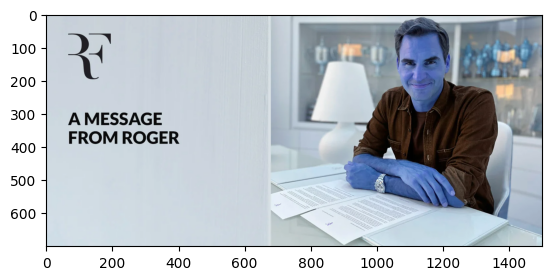

In [4]:
plt.imshow(img); plt.show()

Since the image has more of the unwanted area, we crop it out so as to keep only the required portion by using numpy array properties.

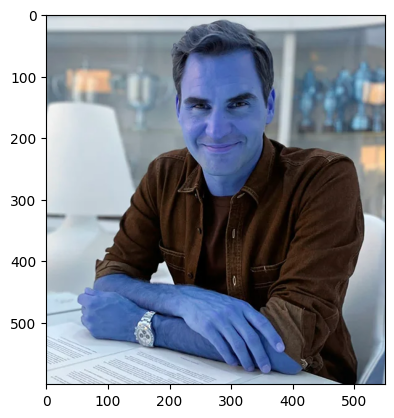

In [5]:
# crop image to get required area only
img = img[0:600, 850:1400]
plt.imshow(img); plt.show()

Let's have the RGB version of the same image by using the module that we imported.

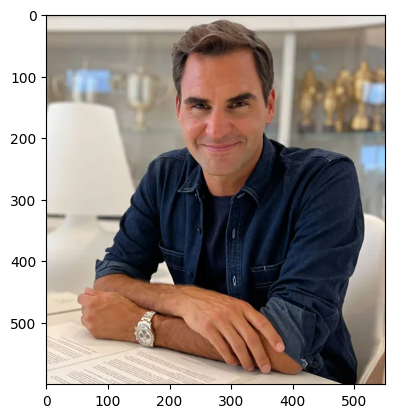

In [6]:
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb); plt.show()

As a matter of fact, image can also be converted to RGB spaces by using the numpy array like below.

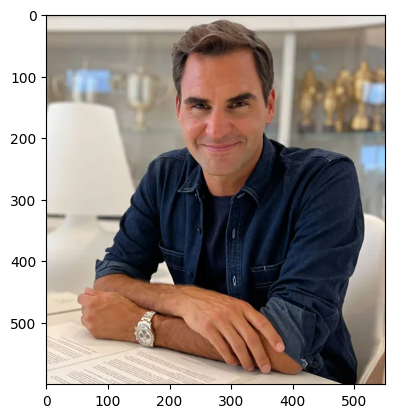

In [7]:
#bgr converted to rgb
plt.imshow(img[:, :, ::-1]); plt.show()

Let's also have the gray image data, it is two dimensional.

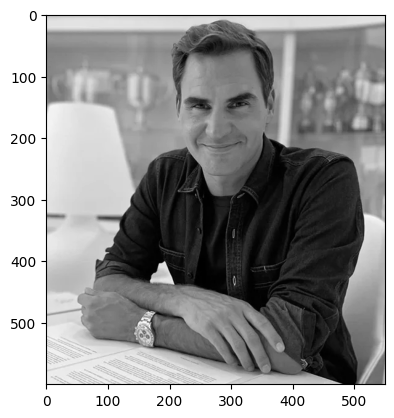

In [8]:
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.imshow(gray, cmap='gray'); plt.show()

In [9]:
gray.shape

(600, 550)

Detet faces and eyes using openCV library and haarcascade thechnique. It provides us a rectangular location where faces and eyes lie by generating list of lists, if it sees multiple faces. For each face, there is a list of four elements representing x / y coordinates, width and height of the image. Then, the technique to detect eyes will work on each face.  

In [10]:
#detect x,y,w,h 
face_cascade = cv2.CascadeClassifier('./opencv/haarcascades/haarcascade_frontalface_default.xml')
eye_cascade = cv2.CascadeClassifier('./opencv/haarcascades/haarcascade_eye.xml')
faces = face_cascade.detectMultiScale(gray, 1.3, 5)
faces

array([[198,  80, 176, 176]], dtype=int32)

By definition, the four elements in above np array represent x-pos, y-pos, height and width of the image.

In [11]:
(x,y,w,h) = faces[0]
f'{x= }, {y= }, {w= }, {h= }'

'x= 198, y= 80, w= 176, h= 176'

We now draw a rectangle covering only the face by using cv2 module.

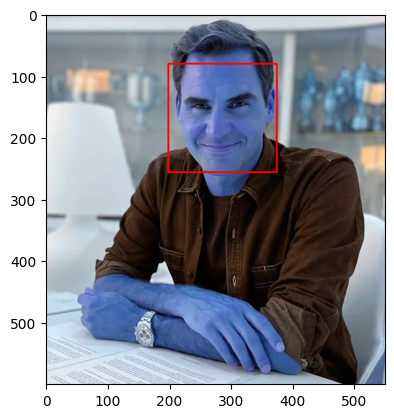

In [12]:
face_img = cv2.rectangle(img, (x,y),(x+w,y+h),(255,0,0),2)
plt.imshow(face_img); plt.show()

After detecting face, we then detect two eyes present on the face image.

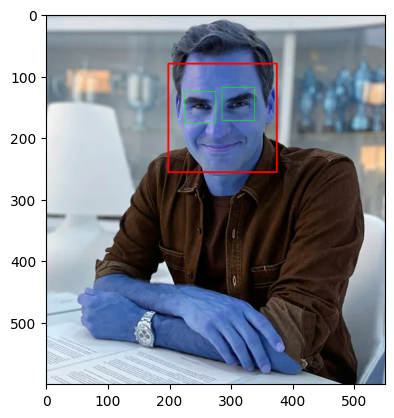

In [13]:
cv2.destroyAllWindows()
for (x,y,w,h) in faces:
    face_img = cv2.rectangle(img, (x,y), (x+w, y+h), (255,0,0), 1)
    roi_gray = gray[y:y+h, x:x+w]
    roi_color = face_img[y:y+h, x:x+w]
    eyes = eye_cascade.detectMultiScale(roi_gray)
    for (ex, ey, ew, eh) in eyes:
        cv2.rectangle(roi_color, (ex, ey), (ex+ew, ey+eh), (0,255,0), 1)

plt.figure()
plt.imshow(face_img, cmap='gray')
plt.show()

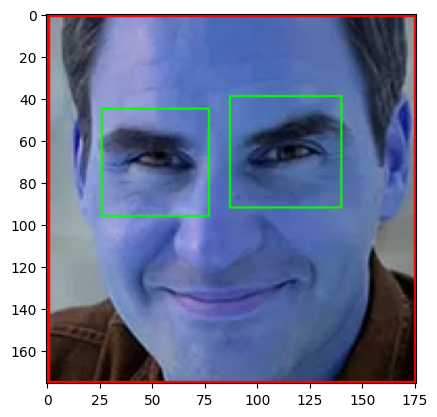

In [14]:
plt.imshow(roi_color, cmap='gray'); plt.show()

In [15]:
cropped_img = np.array(roi_color)
cropped_img.shape

(176, 176, 3)

The cropped image is now converted into wavelets by using wavelt transform module. This technique is used because wavelet transform has several characterstics: it can provide horizontal, vertical, and diagonal multi-directional information. The information is distributed in each individual pixel without interfering with each other, and it can achieve lossless reconstruction in process of image reconstruction.

In [16]:
#wavelet transform
import pywt, cv2

def w2d(img, mode='haar', level=1):
    imArray = img
    #Datatype conversions
    #convert to grayscale, step-1
    imArray = cv2.cvtColor(imArray,cv2.COLOR_RGB2GRAY)
    #convert to float, step-2
    imArray =  np.float32(imArray) 
    imArray /= 255;
    # compute coefficients 
    coeffs = pywt.wavedec2(imArray, mode, level=level)

    #Process Coefficients
    coeffs_H = list(coeffs)  
    coeffs_H[0] *= 0;  

    # reconstruction
    imArray_H = pywt.waverec2(coeffs_H, mode);
    imArray_H *= 255;
    imArray_H =  np.uint8(imArray_H)

    return imArray_H

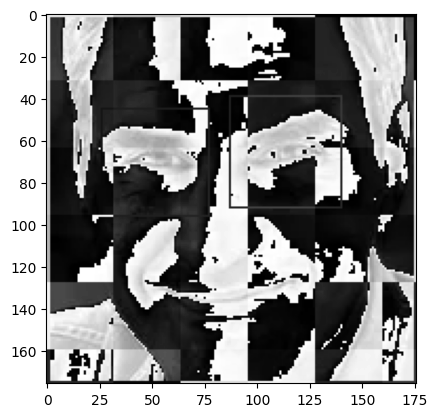

In [17]:
im_har = w2d(cropped_img, 'db1', 5)
plt.imshow(im_har, cmap='gray'); plt.show()

Function to obtain cropped images if two eyes are clearly visible.

In [18]:
def get_cropped_image_if_2_eyes(image_path):
    img = cv2.imread(image_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)
    for (x,y,w,h) in faces:
        roi_gray = gray[y:y+h, x:x+w]
        roi_color = img[y:y+h, x:x+w]
        eyes = eye_cascade.detectMultiScale(roi_gray)
        if len(eyes) >= 2:
            return roi_color

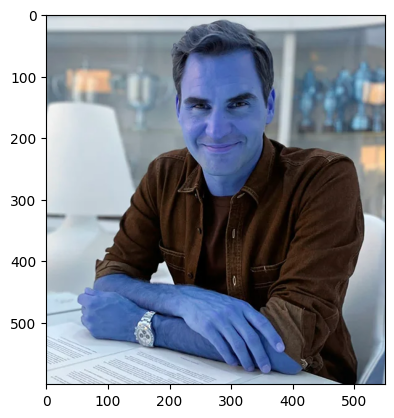

In [19]:
original_image = cv2.imread('./test_images/federer1.jpg')[0:600, 850:1400]
plt.imshow(original_image); plt.show()

unuseful image, returns None

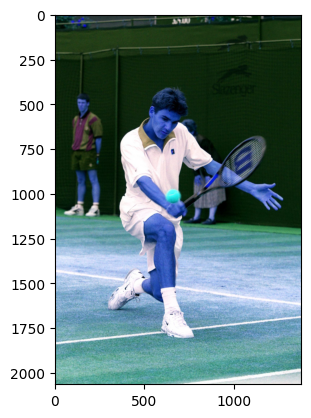

In [20]:
orig_image_obstructed = cv2.imread('./test_images/federer2.jpg')
plt.imshow(orig_image_obstructed); plt.show()

In [21]:
cropped_image_no_2_eyes = get_cropped_image_if_2_eyes('./test_images/messi2.jpg')
cropped_image_no_2_eyes #returns None, because eyes ae not clearly visible

#### Managing variables to save cropped images of useful original images.

In [22]:
path_to_data = './dataset/'
path_to_cr_data = ''.join([path_to_data, 'cropped'])

In [23]:
import os
img_dirs = []

for entry in os.scandir(path_to_data):
    if not entry.name.startswith('.') and entry.name != 'cropped':
        img_dirs.append(entry.path)
        
img_dirs

['./dataset/kylian_mbappe',
 './dataset/maria_sharapova',
 './dataset/virat_kohli',
 './dataset/lionel_messi',
 './dataset/serena_williams',
 './dataset/roger_federer']

In [24]:
import shutil
if os.path.exists(path_to_cr_data):
    shutil.rmtree(path_to_cr_data)
os.mkdir(path_to_cr_data)

Collection of cropped images as preparation for model building.

In [25]:
cropped_image_dirs = []
celebrity_file_names_dict = {}

for img_dir in img_dirs:
    count = 1
    celebrity_name = img_dir.split('/')[-1]
    celebrity_file_names_dict[celebrity_name] = []
    
    for entry in os.scandir(img_dir):
        roi_color = get_cropped_image_if_2_eyes(entry.path)
        
        if roi_color is not None:
            cropped_folder = '/'.join([path_to_cr_data, celebrity_name])
            
            if not os.path.exists(cropped_folder):
                os.makedirs(cropped_folder)
                cropped_image_dirs.append(cropped_folder)
                print(f'Generating cropped images in folder: {cropped_folder}')
                
            cropped_file_name = ''.join([celebrity_name, f'{count}', '.png'])
            cropped_file_path = '/'.join([cropped_folder, cropped_file_name])
            cv2.imwrite(cropped_file_path, roi_color)
            celebrity_file_names_dict[celebrity_name].append(cropped_file_path)
            count += 1

Generating cropped images in folder: ./dataset/cropped/kylian_mbappe
Generating cropped images in folder: ./dataset/cropped/maria_sharapova
Generating cropped images in folder: ./dataset/cropped/virat_kohli
Generating cropped images in folder: ./dataset/cropped/lionel_messi
Generating cropped images in folder: ./dataset/cropped/serena_williams
Generating cropped images in folder: ./dataset/cropped/roger_federer


In [26]:
# celebrity_file_name_dict = {}
class_dict = {}

count = 0
for img_dir in cropped_image_dirs:
    celebrity_name = img_dir.split('/')[-1]
    class_dict[celebrity_name] = count
    
    file_list = []
    for entry in os.scandir(img_dir):
        file_list.append(entry.path)
        
    celebrity_file_names_dict[celebrity_name] = file_list
    count += 1
    
print(celebrity_file_names_dict['serena_williams'][:3])
class_dict

['./dataset/cropped/serena_williams/serena_williams53.png', './dataset/cropped/serena_williams/serena_williams47.png', './dataset/cropped/serena_williams/serena_williams46.png']


{'kylian_mbappe': 0,
 'maria_sharapova': 1,
 'virat_kohli': 2,
 'lionel_messi': 3,
 'serena_williams': 4,
 'roger_federer': 5}

In [27]:
#stackoverflow
X, y = [], []
for celebrity_name, training_files in celebrity_file_names_dict.items():
    for training_image in training_files:
        img = cv2.imread(training_image)
        scalled_raw_img = cv2.resize(img, (32, 32))
        img_har = w2d(img, 'db1', 5)
        scalled_img_har = cv2.resize(img_har, (32, 32))
        combined_img = np.vstack([scalled_raw_img.reshape(32*32*3, 1), scalled_img_har.reshape(32*32, 1)])
        X.append(combined_img)
        y.append(class_dict[celebrity_name])

In [28]:
X = np.array(X).reshape(len(X), 4096).astype(float)
X.shape
#data cleaning process is done

(317, 4096)

In [29]:
#initiative svm
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report


In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
pipe = Pipeline([('scaler', StandardScaler()), ('svc', SVC(kernel='rbf', C=10))])
pipe.fit(X_train, y_train)
np.round(pipe.score(X_test, y_test), 2)

0.94

In [31]:
print(classification_report(y_test, pipe.predict(X_test)))

              precision    recall  f1-score   support

           0       1.00      0.67      0.80         3
           1       1.00      0.88      0.93         8
           2       0.88      0.88      0.88        17
           3       0.91      0.95      0.93        21
           4       0.95      1.00      0.98        20
           5       1.00      1.00      1.00        11

    accuracy                           0.94        80
   macro avg       0.96      0.90      0.92        80
weighted avg       0.94      0.94      0.94        80



In [32]:
#GridSearch
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV

In [33]:
model_params = {
#1
    'svm': {
        'model': svm.SVC(gamma='auto',probability=True),
        'params': {
            'svc__C': [1,10,100,1000],
            'svc__kernel': ['rbf','linear']            
        }
    },
#2  
    'random_forest': {
        'model': RandomForestClassifier(),
        'params': {
            'randomforestclassifier__n_estimators': [1,5,10]
        }
    },
#3  
    'logistic_regression': {
        'model': LogisticRegression(solver='liblinear',multi_class='auto'),
        'params': {
            'logisticregression__C': [1,5,10]
        }
    }
}

In [34]:
scores = []
best_estimators = {}
import pandas as pd

for algo, mp in model_params.items():
    pipe = make_pipeline(StandardScaler(), mp['model'])
    clf = GridSearchCV(pipe, mp['params'], cv=5, return_train_score=False)
    clf.fit(X_train, y_train)
    scores.append({
        'model': algo,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_
    })
    best_estimators[algo] = clf.best_estimator_
    
df = pd.DataFrame(scores, columns=['model', 'best_score', 'best_params'])
df

,model,best_score,best_params
0,svm,0.839805,"{'svc__C': 10, 'svc__kernel': 'rbf'}"
1,random_forest,0.759574,{'randomforestclassifier__n_estimators': 10}
2,logistic_regression,0.877660,{'logisticregression__C': 1}


In [35]:
best_estimators

{'svm': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('svc', SVC(C=10, gamma='auto', probability=True))]),
 'random_forest': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('randomforestclassifier',
                  RandomForestClassifier(n_estimators=10))]),
 'logistic_regression': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('logisticregression',
                  LogisticRegression(C=1, solver='liblinear'))])}

In [36]:
best_estimators['svm'].score(X_test, y_test)

0.9375

In [37]:
best_estimators['random_forest'].score(X_test, y_test)

0.8875

In [38]:
best_estimators['logistic_regression'].score(X_test,y_test)

0.95

In [39]:
best_clf = best_estimators['logistic_regression']
best_clf

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression',
                 LogisticRegression(C=1, solver='liblinear'))])

In [40]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, best_clf.predict(X_test))
cm

array([[ 2,  0,  0,  0,  0,  1],
       [ 0,  8,  0,  0,  0,  0],
       [ 0,  0, 15,  1,  1,  0],
       [ 0,  0,  0, 20,  1,  0],
       [ 0,  0,  0,  0, 20,  0],
       [ 0,  0,  0,  0,  0, 11]])

Text(95.72222222222221, 0.5, 'Truth')

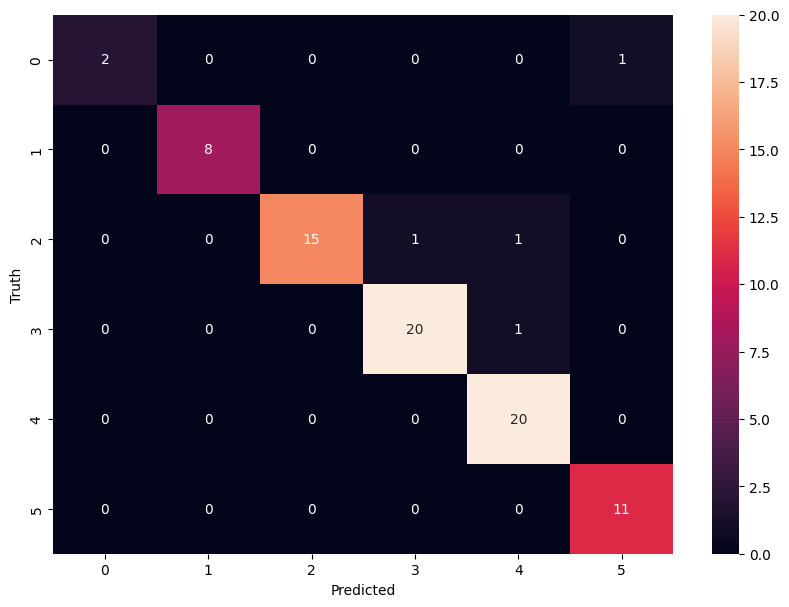

In [51]:
import seaborn as sn
plt.figure(figsize = (10,7))
sn.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [52]:
class_dict

{'kylian_mbappe': 0,
 'maria_sharapova': 1,
 'virat_kohli': 2,
 'lionel_messi': 3,
 'serena_williams': 4,
 'roger_federer': 5}

### Save the trained model

In [41]:
!pip install joblib
import joblib 
# Save the model as a pickle in a file 
joblib.dump(best_clf, 'saved_model.pkl') 

['saved_model.pkl']

### Save class dictionary

In [44]:
import json
with open("class_dictionary.json","w") as f:
    f.write(json.dumps(class_dict))
'Code Finished...'

'Code Finished...'

In [54]:
#wavelets
#https://www.kaggle.com/code/asauve/a-gentle-introduction-to-wavelet-for-data-analysis